In [2]:
#%pip install missingno

In [215]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

In [5]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

**Задание 1:**<br>
Сделать базовый анализ данных: вывести размерность датасетов, посчитать базовые статистики, выполнить анализ пропусков, сделать выводы;

In [19]:
print(f'There are {train.shape[0]} rows & {train.shape[1]} columns in train ')
print(f'There are {test.shape[0]} rows & {test.shape[1]} columns in test')

There are 200000 rows & 202 columns in train 
There are 200000 rows & 201 columns in test


In [35]:
train.head(5)

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7   var_8   var_9  var_10   var_11   var_12   var_13  var_14   var_15   var_16   var_17   var_18   var_19   var_20   var_21   var_22  var_23   var_24   var_25   var_26  var_27  var_28  var_29   var_30   var_31  var_32   var_33   var_34   var_35  var_36  var_37   var_38  var_39   var_40   var_41   var_42   var_43   var_44   var_45   var_46   var_47   var_48   var_49   var_50   var_51  var_52  var_53  var_54   var_55   var_56  var_57  var_58   var_59   var_60   var_61  var_62  var_63  var_64  var_65  var_66   var_67  var_68  var_69   var_70  var_71  var_72   var_73   var_74   var_75   var_76   var_77  var_78   var_79   var_80   var_81   var_82   var_83  var_84   var_85   var_86   var_87   var_88   var_89   var_90  var_91   var_92   var_93   var_94  var_95   var_96   var_97  var_98  var_99  var_100  var_101  var_102  var_103  var_104  var_105  var_106  var_107  var_108  var_109  var_110  var_111  var_112  var_113  var_114  var_115  var_116  var_117  var_118  var_119  var_120  var_121  var_122  var_123  var_124  var_125  var_126  var_127  var_128  var_129  var_130  var_131  var_132  var_133  var_134  var_135  var_136  var_137  var_138  var_139  var_140  var_141  var_142  var_143  var_144  var_145  var_146  var_147  var_148  var_149  var_150  var_151  var_152  var_153  var_154  var_155  var_156  var_157  var_158  var_159  var_160  var_161  var_162  var_163  var_164  var_165  var_166  var_167  var_168  var_169  var_170  var_171  var_172  var_173  var_174  var_175  var_176  var_177  var_178  var_179  var_180  var_181  var_182  var_183  var_184  var_185  var_186  var_187  var_188  var_189  var_190  var_191  var_192  var_193  var_194  var_195  var_196  var_197  var_198  var_199
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266 -4.9200  5.7470  2.9252   3.1821  14.0137   0.5745  8.7989  14.5691   5.7487  -7.2393   4.2840  30.7133  10.5350  16.2191   2.5791  2.4716  14.3831  13.4325  -5.1488 -0.4073  4.9306  5.9965  -0.3085  12.9041 -3.8766  16.8911  11.1920  10.5785  0.6764  7.8871   4.6667  3.8743  -5.2387   7.3746  11.5767  12.0446  11.6418  -7.0170   5.9226 -14.2136  16.0283   5.3253  12.9194  29.0460 -0.6940  5.1736 -0.7474  14.8322  11.2668  5.3822  2.0183  10.1166  16.1828   4.9590  2.0771 -0.2154  8.6748  9.5319  5.8056  22.4321  5.0109 -4.7010  21.6374  0.5663  5.1999   8.8600  43.1127  18.3816  -2.3440  23.4104  6.5199  12.1983  13.6468  13.8372   1.3675   2.9423 -4.5213  21.4669   9.3225  16.4597   7.9984  -1.7069 -21.4494  6.7806  11.0924   9.9913  14.8421  0.1812   8.9642  16.2572  2.1743 -3.4132   9.4763  13.3102  26.5376   1.4403  14.7100   6.0454   9.5426  17.1554  14.1104  24.3627   2.0323   6.7602   3.9141  -0.4851   2.5240   1.5093   2.5516  15.5752 -13.4221   7.2739  16.0094   9.7268   0.8897   0.7754   4.2218  12.0039  13.8571  -0.7338  -1.9245  15.4462  12.8287   0.3587   9.6508   6.5674   5.1726   3.1345  29.4547  31.4045   2.8279  15.6599   8.3307  -5.6011  19.0614  11.2663   8.6989   8.3694  11.5659 -16.4727   4.0288  17.9244  18.5177  10.7800   9.0056  16.6964  10.4838   1.6573  12.1749 -13.1324  17.6054  11.5423  15.4576   5.3133   3.6159   5.0384   6.6760  12.6644   2.7004  -0.6975   9.5981   5.4879  -4.7645  -8.4254  20.8773   3.1531  18.5618   7.7423 -10.1245  13.7241  -3.5189   1.7202  -8.4051   9.0164   3.0657  14.3691  25.8398   5.8764  11.8411 -19.7159  17.5743   0.5857   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   7.8784   8.5635  12.7803  -1.0914
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338  3.1468  8.0851 -0.4032   8.0585  14.0239   8.4135  5.4345  13.7003  13.8275 -15.5849   7.8000  28.5708   3.4287   2.7407   8.5524  3.3716   6.9779  13.8910 -11.7684 -2.5586  5.0464  0.5481  -9.2987   7.8755  1.2859  19.3710  11.3702   0.7399  2.7995  5.8434  10.8160  3.6783 -11.1147   1.8730   9.8775  11.7842   1.2444 -47.3797   7.3718   0.1948  3

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [33]:
pd.set_option('display.max_columns', None) #to display all columns
train.describe()

target          var_0          var_1          var_2          var_3          var_4          var_5          var_6          var_7          var_8          var_9         var_10         var_11         var_12         var_13         var_14         var_15         var_16         var_17         var_18         var_19         var_20         var_21         var_22         var_23         var_24         var_25         var_26         var_27         var_28         var_29         var_30         var_31         var_32         var_33         var_34         var_35         var_36         var_37         var_38         var_39         var_40         var_41         var_42         var_43         var_44         var_45         var_46         var_47         var_48         var_49         var_50         var_51         var_52         var_53         var_54         var_55         var_56         var_57         var_58         var_59         var_60         var_61         var_62         var_63         var_64         var_65         var_66         var_67         var_68         var_69         var_70         var_71         var_72         var_73         var_74         var_75         var_76         var_77         var_78         var_79         var_80         var_81         var_82         var_83         var_84         var_85         var_86         var_87         var_88         var_89         var_90         var_91         var_92         var_93         var_94         var_95         var_96         var_97         var_98         var_99        var_100        var_101        var_102        var_103        var_104        var_105        var_106        var_107        var_108        var_109        var_110        var_111        var_112        var_113        var_114        var_115        var_116        var_117        var_118        var_119        var_120        var_121        var_122        var_123        var_124        var_125        var_126        var_127        var_128        var_129        var_130        var_131        var_132        var_133        var_134        var_135        var_136        var_137        var_138        var_139        var_140        var_141        var_142        var_143        var_144        var_145        var_146        var_147        var_148        var_149        var_150        var_151        var_152        var_153        var_154        var_155        var_156        var_157        var_158        var_159        var_160        var_161        var_162        var_163        var_164        var_165        var_166        var_167        var_168        var_169        var_170        var_171        var_172        var_173        var_174        var_175        var_176        var_177        var_178        var_179        var_180        var_181        var_182        var_183        var_184        var_185        var_186        var_187        var_188        var_189        var_190        var_191        var_192        var_193        var_194        var_195        var_196        var_197        var_198        var_199
count  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.000000  200000.0000

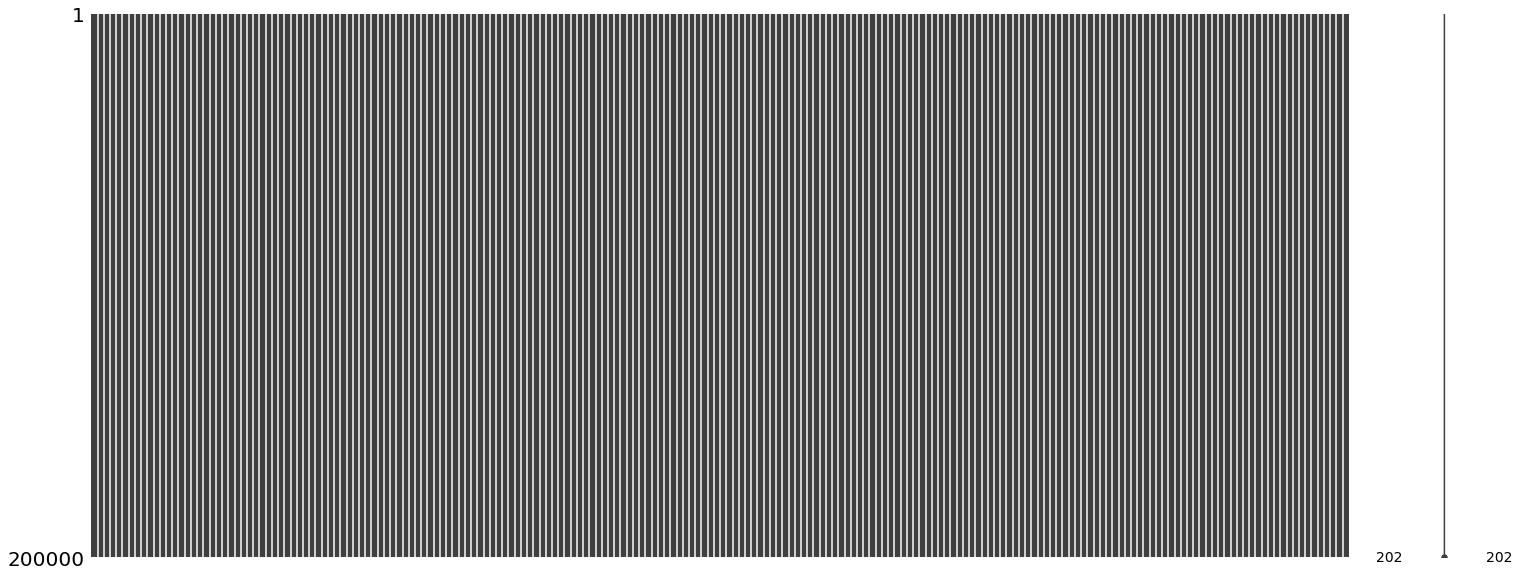

In [36]:
msno.matrix(train)

In [40]:
train.isnull().values.any()

False

In [38]:
test.isnull().values.any()

False

In [69]:
#checking whether the feature is categorical or not
likely_cat = []
for var in train.columns:
    #True or False = number of non unique values / all values less than 1% in our case
    flag = 1.*train[var].nunique() / train[var].count() < 0.01
    if flag == True:
        likely_cat.append(var)
    
likely_cat    

['target', 'var_68']

In [63]:
train['var_68'].value_counts()

5.0214    1084
5.0215    1081
5.0209    1080
5.0183    1077
5.0179    1071
          ... 
5.0407       1
5.0411       1
4.9938       1
4.9989       1
5.0431       1
Name: var_68, Length: 451, dtype: int64

**The result of initial observation**
- We have the dataset with big amount of variables (200) and all of them are float except the "ID" and "target". 
- All values look reasonable and after the initial observation I didn't detect any outliers.
- There are no empty values (NaN)
- We can try to consider as categorical variable only the "var_68" because there are less than 1% of unique values in the column. But after the reconciltion of this column by the describe() function we can say that the assumption is less-likely to be true.

**Задание 2:**
Сделать базовый анализ целевой переменной, сделать выводы;

In [68]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

This is unbalanced classification task where only 10% of the sample belongs to "1" and other to "0"

**Задание 3:** <br>
Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки (если машина не позволяет построить распределение для всех признаков, то выполнить задание для признаков var_0, var_1, var_2, var_5, var_9, var_10, var_13, var_20, var_26, var_40, var_55, var_80, var_106, var_109, var_139, var_175, var_184, var_196), сделать выводы;

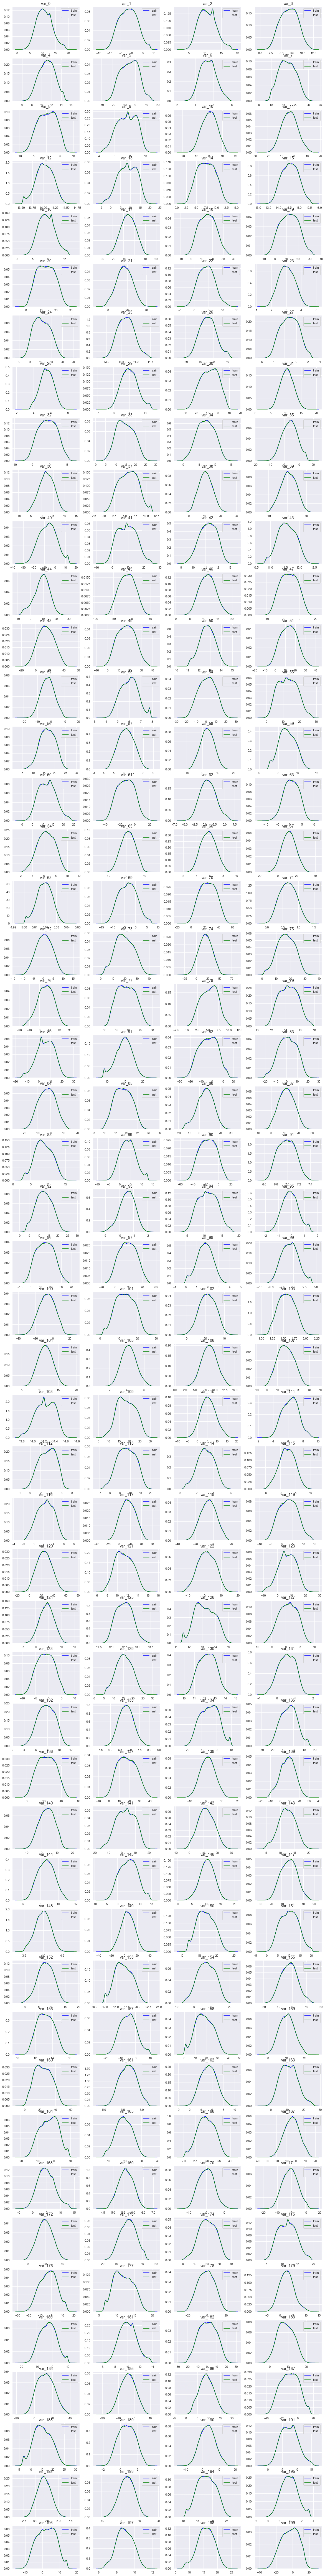

In [228]:
#features distribution
fig, axes = plt.subplots(50, 4, figsize=(20, 20))
fig.set_figheight(170)

for num, feature in enumerate(train.columns[2:]):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//4, num%4], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//4, num%4], color="blue", label="train")
    axes[num//4, num%4].set_title(feature, fontsize=14)

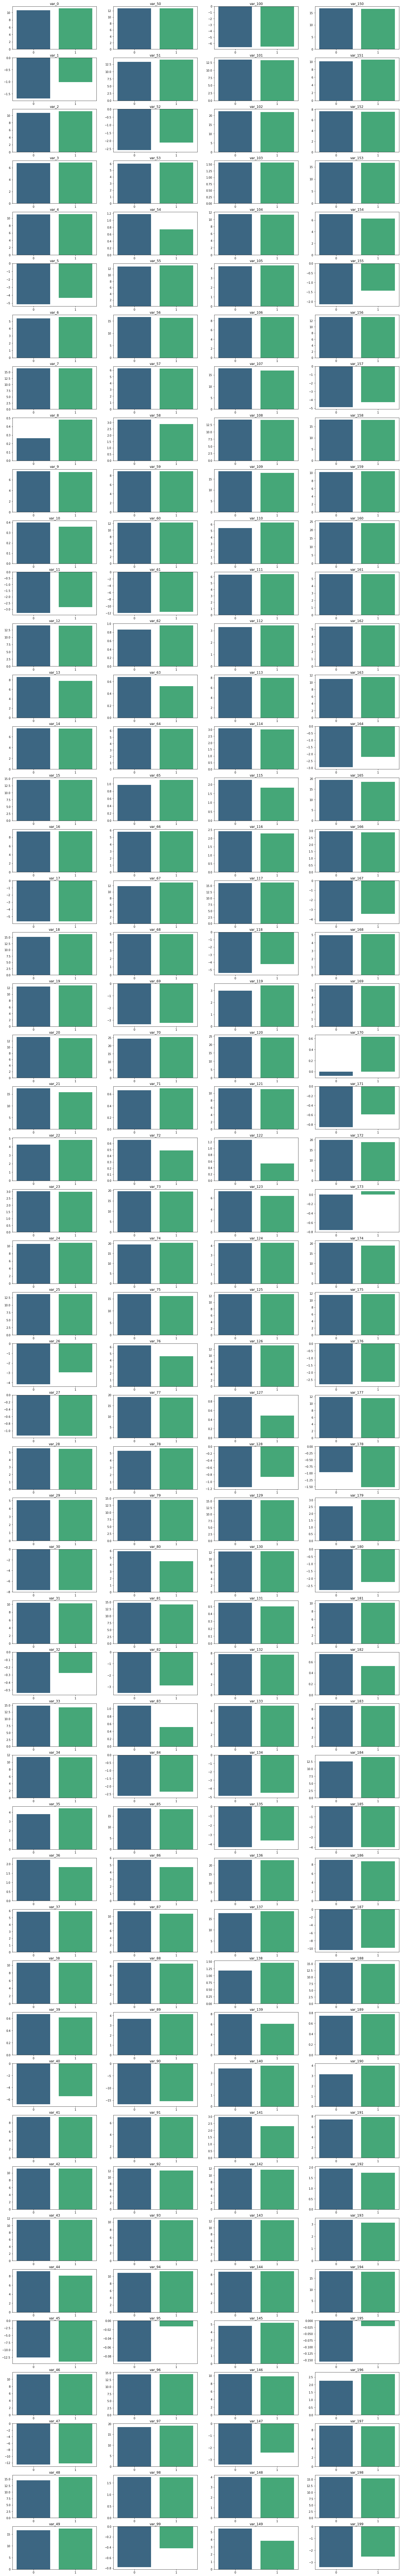

In [187]:
#check average value for target "0" and "1"
fig, axes = plt.subplots(50, 4, figsize=(25, 20))
fig.set_figheight(170)

for num, feature in enumerate(train.columns[2:]):
    data = train.copy()
    statistics = data.groupby('target')[feature].mean()

    ax = sns.barplot(
            x=statistics.index,
            y=statistics.values, 
            palette="viridis",
            ax=axes[num%50, num//50] 
        )
    ax.set_xlabel(None)
    ax.set_title(feature)

In [181]:
features_list = []

for feature in (train.columns[2:]):

    average_diff = data.groupby('target')[feature].mean()[0] - data.groupby('target')[feature].mean()[1]
    min_max_diff = data[feature].max() - data[feature].min()
    diff_percentage = abs(average_diff) / abs(min_max_diff)
    
    if diff_percentage > 0.01:
        features_list.append(feature)
        
features_list

['var_0',
 'var_1',
 'var_2',
 'var_5',
 'var_6',
 'var_8',
 'var_9',
 'var_11',
 'var_12',
 'var_13',
 'var_18',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_26',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_40',
 'var_43',
 'var_44',
 'var_48',
 'var_49',
 'var_51',
 'var_52',
 'var_53',
 'var_56',
 'var_58',
 'var_66',
 'var_67',
 'var_70',
 'var_71',
 'var_75',
 'var_76',
 'var_78',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91',
 'var_92',
 'var_93',
 'var_94',
 'var_95',
 'var_99',
 'var_104',
 'var_105',
 'var_106',
 'var_107',
 'var_108',
 'var_109',
 'var_110',
 'var_111',
 'var_112',
 'var_114',
 'var_115',
 'var_116',
 'var_118',
 'var_119',
 'var_121',
 'var_122',
 'var_123',
 'var_125',
 'var_127',
 'var_128',
 'var_130',
 'var_131',
 'var_132',
 'var_133',
 'var_135',
 'var_137',
 'var_139',
 'var_141',
 'var_144',
 'var_145',
 'var_146',
 'var_147',
 'var_148',
 'var_

In [197]:
f"The list of {len(features_list)} features which affect target's variable most of all."
#To this list was added all variables that have a difference more than 1% between '0' and '1' samples" 

"The list of 122 features which affect target's variable most of all."

- distribution looks similiar for test and train datasets.
- almost third features doesn't have normal distribution
- distribution of features depening on target shows that there are a big number of features which have almost the same average

**Задание 4:** <br>
Построить распределение основных статистики признаков (среднее, стандартное отклонение)<br>
в разрезе целевой переменной и распределение основных статистик обучающей и тестовой выборки, сделать выводы;

**Задание 5:**
Построить распределение коэффициентов корреляции между признаками. <br>
Есть ли зависимость между признаками (будем считать, что связь между признаками отсутствует, если коэффициент корреляции < 0.2)?

In [205]:
pd.set_option('display.max_rows', None)

In [209]:
correlation = train[train.columns[1:]].corr()
corr_with_target = correlation["target"].sort_values(ascending = False)
corr_with_target

target     1.000000
var_6      0.066731
var_110    0.064275
var_53     0.063399
var_26     0.062422
var_22     0.060558
var_99     0.058367
var_190    0.055973
var_2      0.055870
var_133    0.054548
var_0      0.052390
var_1      0.050343
var_179    0.050002
var_40     0.049530
var_184    0.048315
var_78     0.048245
var_170    0.047973
var_191    0.047114
var_94     0.046296
var_67     0.044673
var_18     0.043479
var_173    0.042022
var_164    0.040997
var_118    0.040358
var_147    0.040280
var_91     0.040127
var_89     0.039369
var_95     0.038531
var_155    0.037240
var_35     0.036567
var_71     0.033607
var_106    0.032947
var_162    0.032647
var_157    0.032642
var_48     0.032334
var_163    0.031811
var_180    0.031190
var_5      0.030979
var_119    0.030975
var_145    0.030917
var_167    0.030797
var_49     0.030612
var_32     0.030513
var_130    0.029917
var_90     0.029395
var_24     0.028477
var_195    0.028285
var_125    0.028223
var_135    0.027944
var_52     0.027754


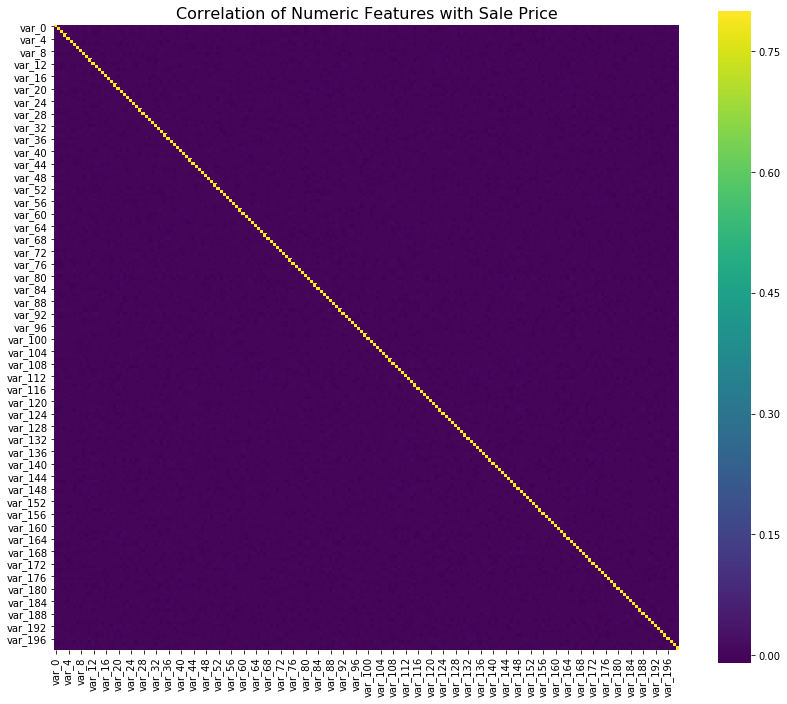

In [211]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features without 'target'", y=1, size=16)
sns.heatmap(train[train.columns[2:]].corr(), square=True, vmax=0.8, cmap="viridis")

**Задание 6:** Выявить 10 признаков, которые обладают наибольшей нелинейной связью с целевой переменной.

In [217]:
parametres = {'max_depth' : 5, 'n_estimators':20, 'random_state':27 }
forest = RandomForestClassifier(**parametres)
forest.fit(train[train.columns[2:]], train['target'])

RandomForestClassifier(max_depth=5, n_estimators=20, random_state=27)

Text(0.5, 1.0, 'What are the top important features to start with?')

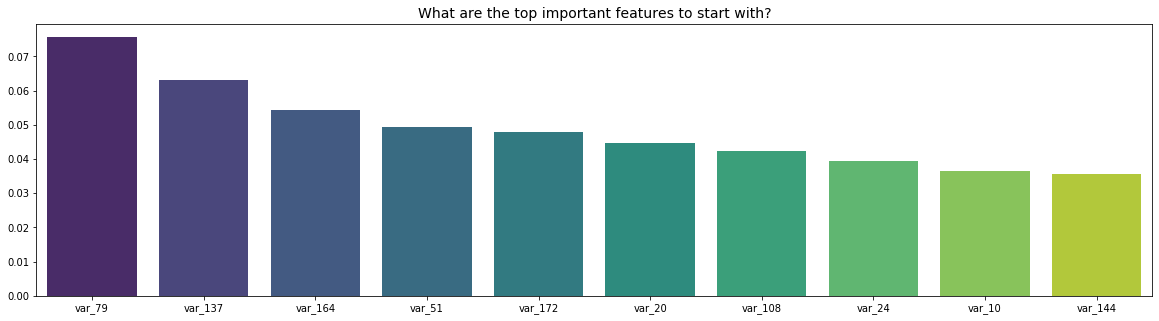

In [219]:
n_top = 10
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train[2:].columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

In [225]:
importance = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:10]
train[2:].columns[idx]

Index(['var_79', 'var_137', 'var_164', 'var_51', 'var_172', 'var_20',
       'var_108', 'var_24', 'var_10', 'var_144'],
      dtype='object')

In [249]:
non_linear_relationships = train[2:].columns[idx].to_list()
non_linear_relationships = non_linear_relationships + ['target']

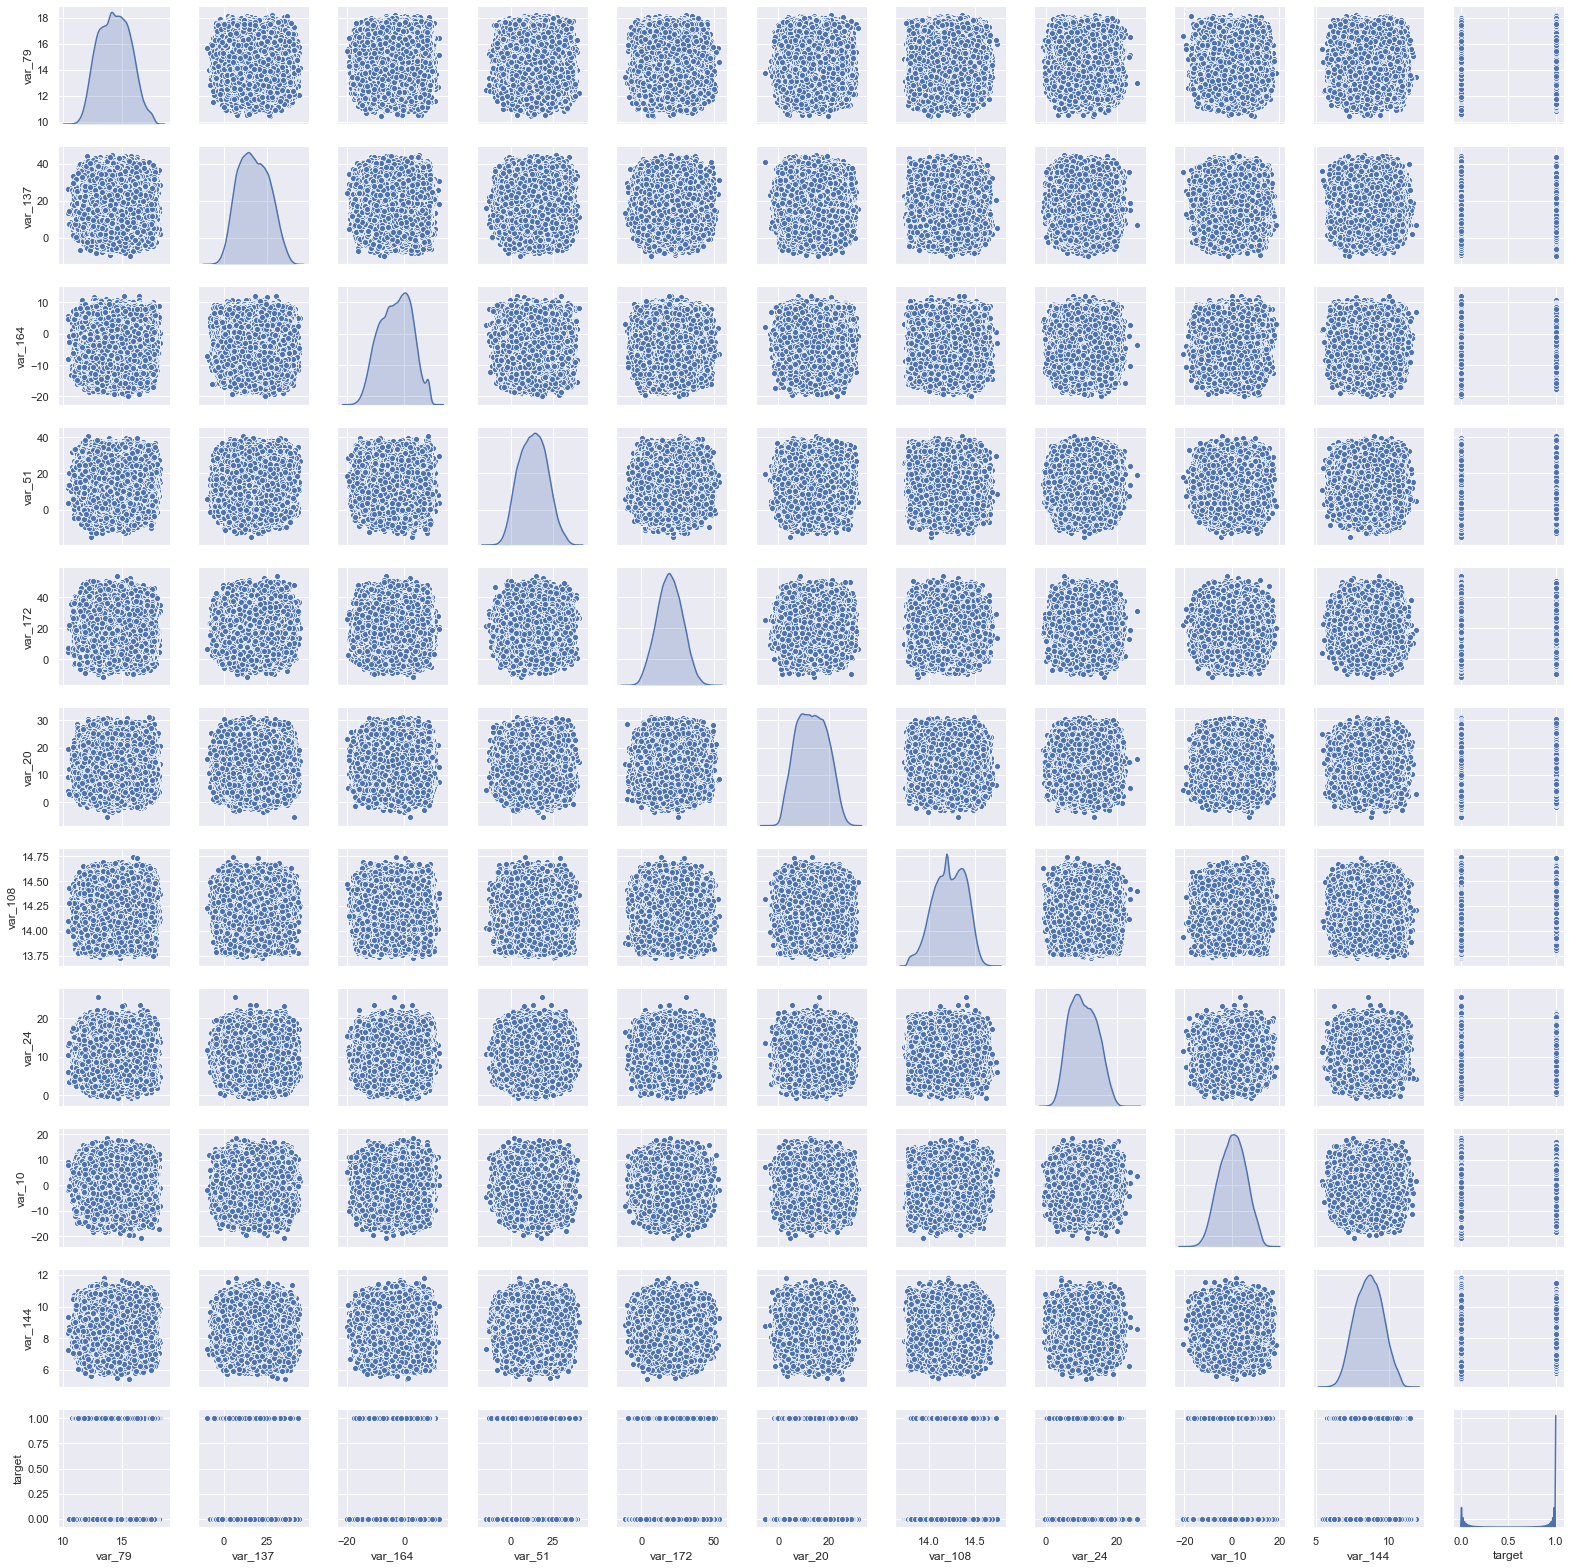

In [251]:
sns.set()

sns.pairplot(train[non_linear_relationships], height=2, kind="scatter", diag_kind="kde")
plt.show()

We can say that all features have very weak influence between each other

**Задание 7:** Провести анализ идентичности распределения признаков на обучающей и тестовой выборках, сделать выводы.

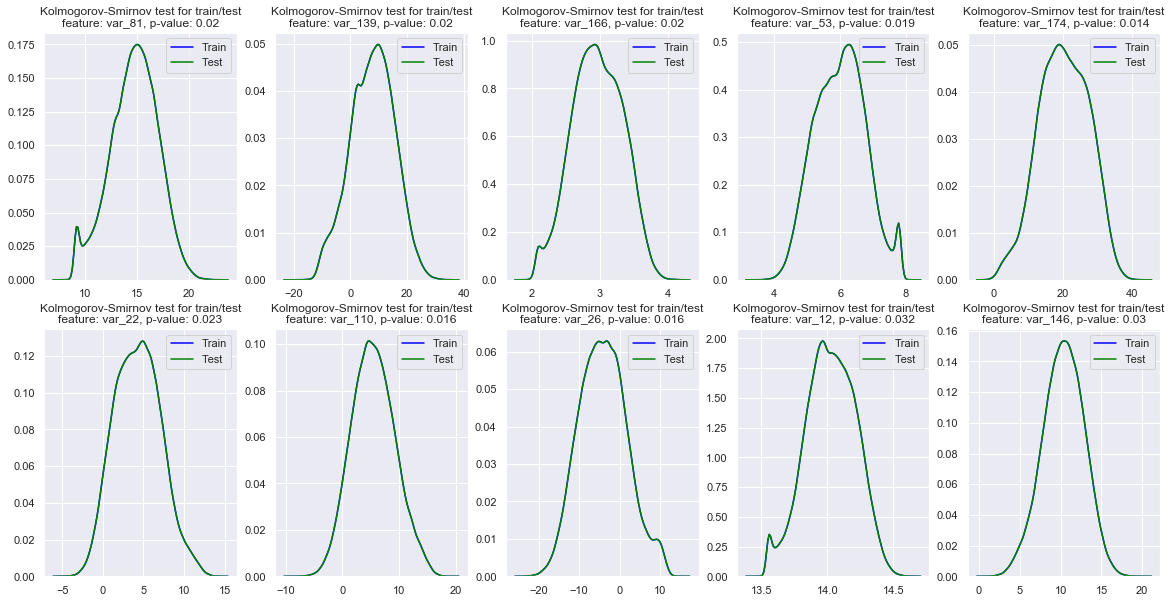

In [261]:
#looks like useless test because almost all features aren't able to pass this test if we take only 500 sample (p-value >0.05).
# But in case when we take 5000 samples all features pass the test :)
statistics_array = []
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for num, feature in enumerate(train.columns[2:][idx]):
    statistic, pvalue = ks_2samp(
        train[feature].sample(5000), test[feature].sample(5000)
    )
    statistics_array.append(statistic)

    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Blue", label="Train")
    sns.kdeplot(train[feature], ax=axes[num//5, num%5], color="Green", label="Test")

    axes[num//5, num%5].set_title(
        (f"Kolmogorov-Smirnov test for train/test\n"
        f"feature: {feature}, p-value: {round(statistic, 3)}")
    )

## Adversarial Validation

In [263]:
X_adv = pd.concat([
    train[train.columns[2:]], test[train.columns[2:]]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [264]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5116
CPU times: user 12min 13s, sys: 7.76 s, total: 12min 21s
Wall time: 7min 8s


There is almost no difference between train and test samples distribution

In [277]:
#%pip install dtale

In [279]:
import dtale

dtale.show(train)